In [10]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import pickle
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# defined
from utility_function import img_resize, model_namer, model_namer_description, save_ml_model, load_ml_model, load_training_data

In [11]:
# model testing

# filename = '3d_cnn2.h5'
# filename = '3d_cnn3.h5'
# img_resize_factor = 100

# filename = 'cnn3d_100_5_1.75e-14_100_1_relu_50.h5'
# filename = 'cnn3d_100_5_1.75e-14_50_1_relu_50.h5'
# filename = 'cnn3d_1000_5_1.75e-14_40_1_tanh_1.h5'
# filename = 'cnn2d_1000_5_1.75e-14_50_1_relu_100.h5'
# filename = 'cnn2d_1000_5_1.75e-14_100_1_tanhmax_100.h5'
# filename = 'cnn3d_2000_5_1.75e-14_50_1_relu-dense_1.pkl'
# filename = 'cnn2d_1000_5_1.75e-14_50_255_max_100.pkl'
filename = 'cnn2d_1000_5_1.75e-14_50_255_max_100.pkl'

info = model_namer_description(filename)
img_resize_factor = int(info['img_resize'])

model = load_ml_model(filename)

Model description:
 
                - Dimension: 2
 
                - Number of samples: 1000

                - FMC subsampling frequency: 5

                - FMC scaler: 1.75e-14

                - Img resize factor: 50

                - Img scaler: 255

                - Remark: max

                - Epochs: 100

    


In [22]:
x_dimension = 2
img_resize_factor = 50
img_scaler = 255
epochs = 100

X, y = load_training_data(num_sample=1000, 
                          x_dimension=x_dimension, 
                          img_resize_factor=img_resize_factor, 
                          img_scaler = img_scaler)

The shape of X is (1000, 895, 256, 1)
The shape of y is (1000, 7200)


(-0.5, 119.5, 59.5, -0.5)

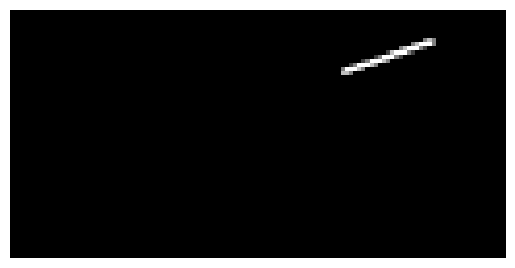

In [29]:
true_img = y[999].reshape(int(120*img_resize_factor/100), int(240*img_resize_factor/100))
fig, ax = plt.subplots()
ax.imshow(true_img, cmap ='gray')
plt.axis('off')

1/1 [==============================] - 0s 45ms/step


(-0.5, 119.5, 59.5, -0.5)

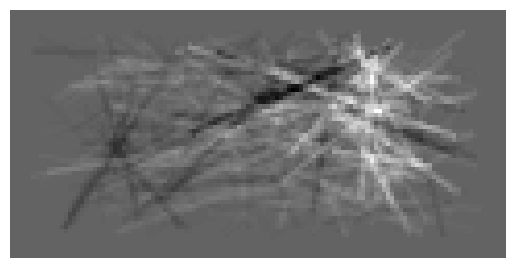

In [28]:
ypred = model.predict(X[999].reshape(-1, 895, 256, 1))*img_scaler
img = ypred.reshape(int(120*img_resize_factor/100), int(240*img_resize_factor/100))
fig, ax = plt.subplots()
ax.imshow(img, cmap ='gray')
plt.axis('off')


(7200,)